In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Constante universal dos gases
R = 8.3144598 #L.KPa/mol.K

# Parametros da EoS SRK
OMEGA = 0.08664
PSI = 0.42748 

In [3]:
# Calculo dos volumes, em litros, com a pressão em KPa, utilizando a EoS SRK
def SRK(P,T):

    global a
    global b
        
    # Pressao e temperatura reduzidas
    T_r = T/T_crit
    P_r = P/P_crit

    # Parametros da EoS SRK
    alfa = (1 + (0.480 + 1.574*ACENTRIC_FACTOR - 0.176*(ACENTRIC_FACTOR**2))*(1 - (T_r**0.5)))**2
    a = (PSI*alfa*(R**2)*(T_crit**2))/P_crit
    b = (OMEGA*R*T_crit)/P_crit
    
    # Coeficientes da forma polinomial da EoS SRK
    coef = [0]*4
    coef[0] = P
    coef[1] = -R*T
    coef[2] = -(P*(b**2) + b*R*T - a)
    coef[3] = -a*b

    # Raizes da EoS SRK para P e T especificados
    vol = np.roots(coef)
    return(vol)

In [4]:
# Funcao para calcular a pressao de saturacao
def calc_Psat(P,T):
    
    ERRO_MIN = 1*(10**(-9))
    ITER=0
    ITER_MAX = 1000
    erro = 1
    
    while(erro>ERRO_MIN and ITER<ITER_MAX):
        
        # Raizes de SRK em litros
        vol = SRK(P,T)
        # Teste para determinar se há raízes imaginárias
        for comp_vol in vol:
            if(np.dtype('Float64')!=type(comp_vol)):
                return
        
        # Parametros para o calculo de G residual
        beta = (b*P)/(R*T)
        q = a/(b*R*T)
        
        #Liquido
        Z_liq = (min(vol))*P/(R*T)
        I_liq = np.log((Z_liq + beta)/Z_liq)
        G_res_liq = R*T*(Z_liq -1 -np.log(Z_liq - beta) - q*I_liq) #G residual do liquido
        phi_liq = np.exp(G_res_liq/(R*T))
        
        #Vapor 
        Z_vap = (max(vol))*P/(R*T)
        I_vap = np.log((Z_vap + beta)/Z_vap)
        G_res_vap = R*T*(Z_vap - 1 - np.log(Z_vap - beta) - q*I_vap) #G residual do vapor
        phi_vap = np.exp(G_res_vap/(R*T)) 
        erro = np.abs(1 - phi_liq/phi_vap) # Criterio de convergencia phi_liq/phi_vap < 1.10^-9
        ITER += 1
        P = P*(phi_liq/phi_vap)
       
    return(P)    

In [5]:
#Calcula o parametro q de SRK em funcao da temperatura reduzida. Esta funcao sera utilizada na derivada numerica de q
def q_function(T_r):
    alfa = (1 + (0.480 + 1.574*ACENTRIC_FACTOR - 0.176*(ACENTRIC_FACTOR**2))*(1 - (T_r**0.5)))**2
    q = PSI*alfa/(OMEGA*T_r)
    return(q)

In [6]:
# Calcula as propriedade termodinamicas H e S das fases liquida e vapor
def propriedades_termodinamicas(P,T):
    
    # Raizes de SRK
    vol = SRK(P,T)
    # Teste para determinar se há raizes imaginarias
    for comp_vol in vol:
        if(np.dtype('Float64')!=type(comp_vol)):
            return
    
    # Parâmetros para o cálculo de G residual
    beta = (b*P)/(R*T)
    T_r = T/T_crit
    
    # Cálculo da derivada numérica de q em relação à temperatura reduzida
    h = 1*(10**(-5))
    dqdT_r = (q_function(T_r + h) - q_function(T_r - h))/(2*h)
            
    #Líquido
    Z_liq = (min(vol))*P/(R*T)
    I_liq = np.log((Z_liq + beta)/Z_liq)
    
    #Propriedades residuais
    G_res_liq = R*T*(Z_liq -1 -np.log(Z_liq - beta) - q_function(T_r)*I_liq)
    H_res_liq = R*T*(Z_liq - 1 + T_r*dqdT_r*I_liq)
    S_res_liq = R*(np.log(Z_liq - beta) + (q_function(T_r) + T_r*dqdT_r)*I_liq)
    
    #Vapor 
    Z_vap = (max(vol))*P/(R*T)
    I_vap = np.log((Z_vap + beta)/Z_vap)
    
    #Propriedades residuais
    G_res_vap = R*T*(Z_vap - 1 - np.log(Z_vap - beta) - q_function(T_r)*I_vap)
    H_res_vap = R*T*(Z_vap - 1 + T_r*dqdT_r*I_vap)
    S_res_vap = R*(np.log(Z_vap - beta) + (q_function(T_r) + T_r*dqdT_r)*I_vap)
    
    #Propriedades termodinâmicas do gás ideal
    Tref = 273.15 + 25 #K
    Pref = 101.325 #KPa
    tau = T/Tref
    MCPH = coef_Cp[0]+(coef_Cp[1]*Tref*(1+tau))/2+(coef_Cp[2]*(Tref**2)*((tau**2)+tau+1)/3)+(coef_Cp[3]/(tau*(Tref**2)))
    MCPS = coef_Cp[0]+(coef_Cp[1]*Tref+(coef_Cp[2]*(Tref**2)+coef_Cp[3]/((tau**2)*(Tref**2)))*((tau+1)/2))*((tau-1)/np.log(tau))
    H_ideal = R*MCPH*(T - Tref)
    S_ideal = R*MCPS*np.log(tau) - R*np.log(P/Pref)
    
    #Propriedades termodinâmicas
    H_real_vap = H_ideal + H_res_vap
    H_real_liq = H_ideal + H_res_liq
    S_real_vap = S_ideal + S_res_vap
    S_real_liq = S_ideal + S_res_liq
    
    return(H_real_vap,H_real_liq,S_real_vap,S_real_liq)    

In [7]:
#Cálculo da pressão de saturação via Antoine
def antoine(T):
    P_sat_ant = np.exp(coef_antoine[0] - coef_antoine[1]/((T - 273.15) + coef_antoine[2]))
    return(P_sat_ant)

In [8]:
# Menu para escolher o composto puro

print('Programa para calcular a pressao de saturacao de diferentes compostos')
option = int(input('Escolha o composto quimico para o calculo de Psat:\n\nwater(1)\nethanol(2)\n'))

# Water
if (option==1):
    P_crit = 2.2055*(10**4) #KPa
    T_crit = 647.1 #K
    ACENTRIC_FACTOR = 0.345
    T_zero = 293.15 #K     # Temperatura inicial 
    factor = (647.09 - T_zero)/50
    coef_antoine = [16.3872, 3885.70, 230.170]
    coef_Cp = [3.470, 1.450*(10**(-3)), 0, 0.121*(10**5)]
    composto = 'Water'
    arquivo = 'water_experimental.txt'
    
# Ethanol
elif (option==2):
    T_crit = 513.9 #K
    P_crit = 6.148*(10**3) #KPa
    ACENTRIC_FACTOR = 0.645
    T_zero = 273.15 #K     # Temperatura inicial 
    factor = (351.70 - T_zero)/50
    coef_antoine = [16.8958, 3795.17, 230.918]
    coef_Cp = [3.518, 20.001*(10**(-3)), -6.002*(10**(-6)), 0]
    composto = 'Ethanol'
    arquivo = 'ethanol_experimental.txt'

else:
    print('Escolha inválida. Tente novamente')
    quit

Programa para calcular a pressao de saturacao de diferentes compostos
Escolha o composto quimico para o calculo de Psat:

water(1)
ethanol(2)
2


In [9]:
# Acessando os arquivos .txt com os dados experimentais de P_sat
arquivo_manipulado = open(arquivo, 'r')

P_sat_exp = []   #KPa
T_exp = []       #K

for linha in arquivo_manipulado:
    valores = linha.split()
    T_exp.append(float(valores[0]))
    P_sat_exp.append(float(valores[1]))
    
arquivo_manipulado.close()

In [13]:
P_sat_KPa = []         #lista para alocar as pressões de saturação calculadas por SRK para o plot
P_sat_antoine = []     #lista para alocar as pressões de saturação calculadas via Antoine para o plot
Temp_K = []
H_vap = []
H_liq = []
S_vap = []
S_liq = []
i = 0
P = 100 #KPa

while i < len(T_exp):

    T = T_exp[i] #K
    P_sat = calc_Psat(P,T) #KPa
    P = P_sat        
    if(type(None)!=type(P_sat)):
        P_sat_antoine.append(antoine(T))
        P_sat_KPa.append(P_sat) # alocação de P_sat em uma lista
        Temp_K.append(T)
        [H_v,H_l,S_v,S_l] = propriedades_termodinamicas(P_sat,T)
        H_vap.append(H_v)
        H_liq.append(H_l)
        S_vap.append(S_v)
        S_liq.append(S_l)
        i +=1
        
    else:        
        break

C:\Users\mauricio\Anaconda3\lib\site-packages\ipykernel\__main__.py:42: RuntimeWarning: invalid value encountered in double_scalars


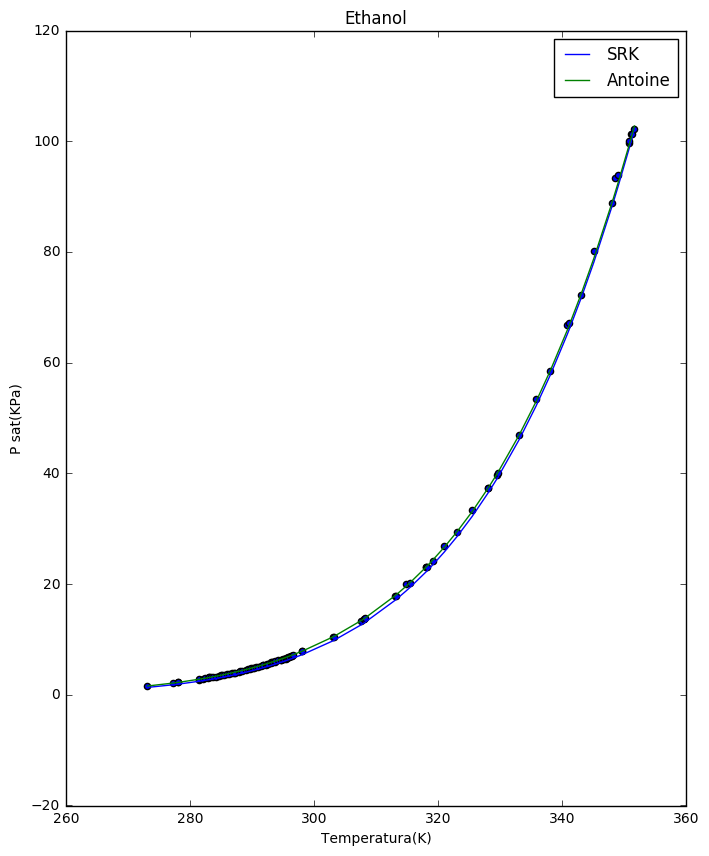

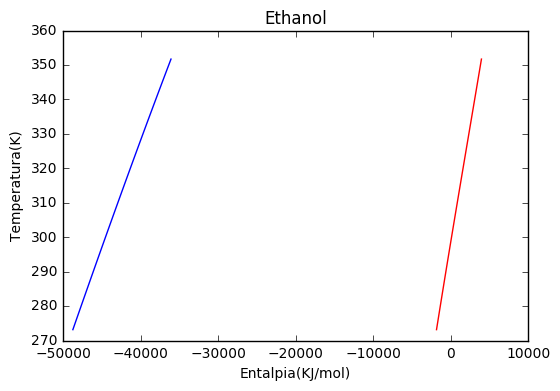

[29.651767151218255, 28.180880269577976, 27.875420827646408, 27.865074741477869, 26.753618377114424, 26.72074939858383, 26.524521081195516, 26.427037813064292, 26.297710782669085, 26.204411728162743, 26.201201440976455, 26.13709239433383, 26.009425429507669, 25.882490195060438, 25.693451221791104, 25.630800085879752, 25.537161042558417, 25.443925820186173, 25.289426988507422, 25.197261119237474, 25.074992469336362, 24.983753398626749, 24.923146710852869, 24.712398254205088, 24.664526137607723, 24.592925567232722, 24.385506902918415, 24.267923672892142, 24.209387476510891, 24.15102098159857, 24.034795369602829, 24.005844356431091, 23.91924339414129, 23.804361628987284, 23.690146664315325, 23.604920986584798, 23.576595106571194, 23.463703578339111, 23.407504274228476, 23.351468718212189, 23.23988718066397, 23.212093487377814, 23.198211858699324, 23.15662776678991, 23.073732574575487, 23.046181540894352, 22.909029283775869, 22.800027894466936, 22.772877178954722, 22.718694949500765, 22.63

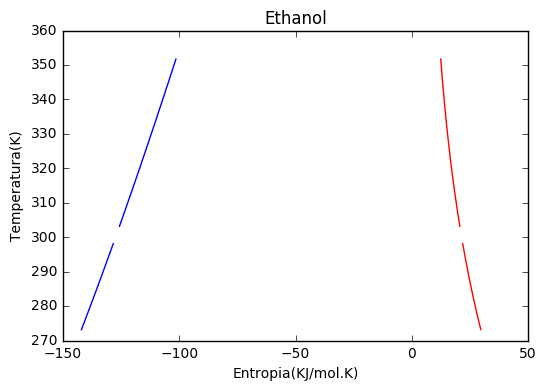

In [12]:
# Plot
plt.figure(1) 
eixos = plt.subplots(figsize=(8,10))
plt.title(composto)
plt.xlabel('Temperatura(K)')
plt.ylabel('P sat(KPa)')
plt.plot(Temp_K,P_sat_KPa, label='SRK')
plt.scatter(T_exp,P_sat_exp)#,'r', label='Experimental')
plt.plot(Temp_K,P_sat_antoine, label='Antoine')
plt.legend(loc=0)
plt.show()

plt.figure(2)
plt.title(composto)
plt.xlabel('Entalpia(KJ/mol)')
plt.ylabel('Temperatura(K)')
plt.plot(H_vap,Temp_K,'r')
plt.plot(H_liq,Temp_K,'b')
plt.show()

plt.figure(3)
plt.title(composto)
plt.xlabel('Entropia(KJ/mol.K)')
plt.ylabel('Temperatura(K)')
plt.plot(S_vap,Temp_K,'r')
plt.plot(S_liq,Temp_K,'b')
print(S_vap)
print(S_liq)
print(Temp_K)
plt.show()